Import the required libraries:

In [1]:
import nltk
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
df=pd.read_csv("training_data_lowercase.csv", sep='\t', names=["labels", "text"], header=None)
print(df.columns)
print(df.head())

Index(['labels', 'text'], dtype='object')
   labels                                               text
0       0  donald trump sends out embarrassing new year‚s...
1       0  drunk bragging trump staffer started russian c...
2       0  sheriff david clarke becomes an internet joke ...
3       0  trump is so obsessed he even has obama‚s name ...
4       0  pope francis just called out donald trump duri...


In [4]:

data_train=df["text"]
data_test=df["labels"]

In [5]:
def tokenize_text(text):
    if isinstance(text, str):

        return word_tokenize(text)   # returns a list of tokens
    else:
        return []
data_token=data_train.apply(tokenize_text)
# filter_data=data_train.apply(tokenize_text)

Remove stop words

In [6]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words_clean = [word for word in text if word not in stop_words]
    return ' '.join(words_clean)

filter_data=data_token.apply(remove_stop_words)

print(filter_data.head())

0    donald trump sends embarrassing new year‚s eve...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obama‚s name coded website...
4    pope francis called donald trump christmas speech
Name: text, dtype: object


split the data for train and test

In [7]:
from sklearn.model_selection import train_test_split

# X=filter_data.to_frame(name='text')
# y=data_test.to_frame(name='labels')
X=filter_data
y=data_test
print(X)
print(y)
print(X.isna().sum())
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape)
print(X_test.shape)

0        donald trump sends embarrassing new year‚s eve...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes internet joke thr...
3        trump obsessed even obama‚s name coded website...
4        pope francis called donald trump christmas speech
                               ...                        
34147         tears rain thais gather late king 's funeral
34148    pyongyang university needs non-u.s. teachers t...
34149    philippine president duterte visit japan ahead...
34150           japan 's abe may election many n't want pm
34151    demoralized divided : inside catalonia 's poli...
Name: text, Length: 34152, dtype: object
0        0
1        0
2        0
3        0
4        0
        ..
34147    1
34148    1
34149    1
34150    1
34151    1
Name: labels, Length: 34152, dtype: int64
0
(27321,)
(6831,)


Load the vectorizer and vectorize the data

In [8]:
print(X_train.shape)
X_train_str = [' '.join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in X_train]
X_test_str  = [' '.join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in X_test]
tfidf = TfidfVectorizer(
     max_features=5000,
    analyzer='char', ngram_range=(1,5)
)


X_train_tfidf = tfidf.fit_transform(X_train_str)
X_val_tfidf = tfidf.transform(X_test_str)

(27321,)


In [22]:
# Download the zip file
!wget http://nlp.stanford.edu/data/glove.6B.zip

# Unzip it
!unzip glove.6B.zip


--2025-10-31 10:29:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-31 10:29:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-31 10:29:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [25]:
import numpy as np
embedding_dim = 100  # depends on your pretrained embeddings
embedding_index = {}  # Load GloVe vectors here

with open('glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector


def get_doc_embedding(doc, tokenizer, embedding_index, embedding_dim):
    words = doc.split()
    vectors = [embedding_index[w] for w in words if w in embedding_index]
    if len(vectors) == 0:
        return np.zeros(embedding_dim)
    return np.mean(vectors, axis=0)

X_embed = np.array([get_doc_embedding(doc, None, embedding_index, embedding_dim) for doc in X_train])

X_val_embed = np.array([get_doc_embedding(doc, None, embedding_index, embedding_dim) for doc in X_test])



In [26]:
from scipy.sparse import hstack
# Convert embeddings to sparse if necessary
from scipy.sparse import csr_matrix

X_embed_sparse = csr_matrix(X_embed)
X_hybrid = hstack([X_train_tfidf, X_embed_sparse])

X_val_embed_sparse = csr_matrix(X_val_embed)  # embeddings for X_val
X_val_hybrid = hstack([X_val_tfidf, X_val_embed_sparse])

modal

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6
)
# from sklearn.linear_model import  LogisticRegression

# model = LogisticRegression(max_iter=500)

In [28]:
model.fit(X_hybrid, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

prediction

In [31]:
y_pred = model.predict(X_val_hybrid)

Accuracy

In [33]:
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9655980090762699
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3529
           1       0.96      0.97      0.96      3302

    accuracy                           0.97      6831
   macro avg       0.97      0.97      0.97      6831
weighted avg       0.97      0.97      0.97      6831



Confusion matrix

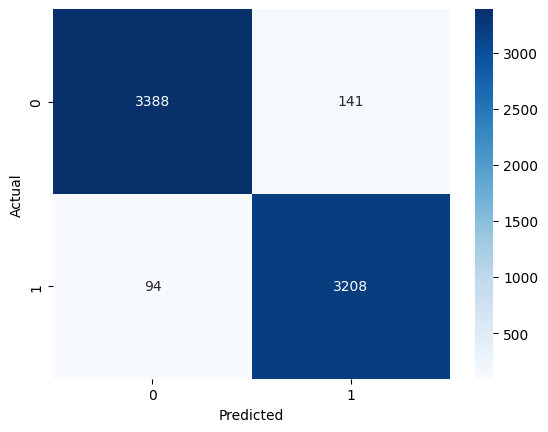

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()